In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.model_selection
import skimage.exposure
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base_dir = '../input/finding-lungs-in-ct-data/'
working_dir = '../working/'
images_lib = working_dir + '2d_images'
masks_lib = working_dir + '2d_masks'

In [3]:
with zipfile.ZipFile( base_dir+"2d_images.zip", "r" ) as zip_ref:
    zip_ref.extractall(  "2d_images" )
    
with zipfile.ZipFile( base_dir+"2d_masks.zip", "r" ) as zip_ref:
    zip_ref.extractall( "2d_masks" )
    
with zipfile.ZipFile( base_dir+"3d_images.zip", "r" ) as zip_ref:
    zip_ref.extractall( "3d_images" )

In [4]:
image_shape = 128
SEED = 42

In [5]:
all_images = tf.io.gfile.glob( working_dir + '/2d_images/*.tif' ) 
all_images = sorted( all_images )

all_masks = tf.io.gfile.glob( working_dir + '/2d_masks/*.tif' )
all_masks = sorted( all_masks )

In [6]:
def rgb2gray( image ):
    return np.dot( image[...,:3], [0.2989, 0.5870, 0.1140] )

def four_to_one( arr ):
    return arr[:, :, 0]*0.25 + arr[:, :, 1]*0.25 + arr[:, :, 2]*0.25+ arr[:, :, 3]*0.25

def HistogramEqualization( image, number_bins=256 ):
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return image_equalized.reshape( image.shape )

def AdaptiveHistogramEqualization( image ):
    image = image / 255.0
    image = skimage.exposure.equalize_adapthist( image, clip_limit=0.03 )
    return image

In [7]:
def preprocessing( arr_dir ):
    arr = plt.imread( arr_dir )
    arr= rgb2gray( arr )
    arr = AdaptiveHistogramEqualization( arr )
    arr = ( arr - np.min( arr ) ) / ( np.max( arr ) - np.min( arr ) )
    arr = np.expand_dims( arr[::4, ::4], 2 )
    return arr

In [8]:
def preprocessing_test( arr_dir ):
    arr = plt.imread( arr_dir )
    arr = ( arr - np.min( arr ) ) / ( np.max( arr ) - np.min( arr ) )
    arr = np.expand_dims( arr[::4, ::4], 2 )
    return arr

In [9]:
images = np.stack(  [ preprocessing( i ) for i in all_images ] , axis=0)
masks = np.stack(  [ preprocessing_test( i ) for i in all_masks ] , axis=0)

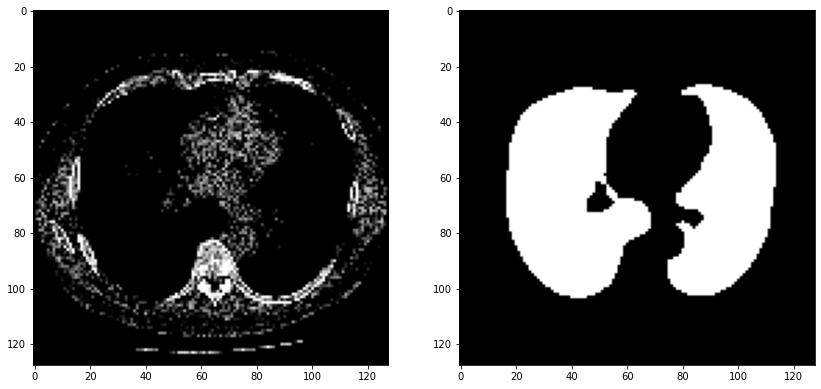

In [10]:
fig, ax = plt.subplots( 1,2, figsize = (14, 8) );
ax[0].imshow( images[10][:,:,0], cmap='gray' );
ax[1].imshow( masks[10][:,:,0], cmap='gray' );

In [11]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split( images, masks, test_size=0.1 )

In [12]:
print( 'Training input is', x_train.shape )
print( 'Training output is {}, min is {}, max is {}'.format( y_train.shape, y_train.min(), y_train.max() ) )
print( 'Testing set is', x_val.shape )

Training input is (240, 128, 128, 1)
Training output is (240, 128, 128, 1), min is 0.0, max is 1.0
Testing set is (27, 128, 128, 1)


In [13]:
x_train.shape[1:], x_train[0].max()

((128, 128, 1), 1.0)

In [14]:
def my_generator( x_train, y_train, batch_size ):
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range = 10,
        zoom_range = 0.1,
    ).flow( x_train, x_train, batch_size, seed = SEED )
    
    mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range = 10,
        zoom_range = 0.1 
    ).flow( y_train, y_train, batch_size, seed = SEED )
    
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

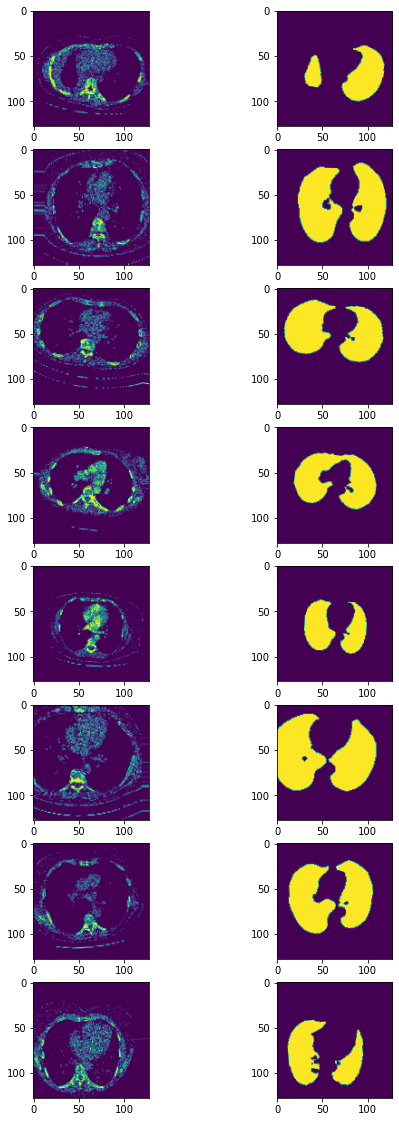

In [15]:
image_batch, mask_batch = next(
    my_generator( x_train, y_train, 8 ) )

fig, ax = plt.subplots( 8, 2, figsize = ( 8, 20 ) )
for i in range(8):
    ax[i, 0].imshow( image_batch[ i, :, :, 0 ] )
    ax[i, 1].imshow( mask_batch[ i, :, :, 0 ] )

In [16]:
def dice_coef(y_true, y_pred):
    '''
    Params: y_true -- the labeled mask corresponding to an rgb image
            y_pred -- the predicted mask of an rgb image
    Returns: dice_coeff -- A metric that accounts for precision and recall
                           on the scale from 0 - 1. The closer to 1, the
                           better.
    '''
    y_true_f = tf.keras.backend.flatten( y_true )
    y_pred_f = tf.keras.backend.flatten( y_pred )
    intersection = tf.keras.backend.sum( y_true_f * y_pred_f )
    smooth = 1.0
    return ( 2.0 * intersection + smooth ) / ( tf.keras.backend.sum( y_true_f ) + tf.keras.backend.sum( y_pred_f ) + smooth )

def dice_coef_loss( y_true, y_pred ):
    return 1. - dice_coef( y_true, y_pred )

In [17]:
def iou( y_true, y_pred ):
    y_pred = tf.keras.backend.cast(
        tf.keras.backend.greater( y_pred, .5 ),
        dtype='float32'
    )
    
    inter = tf.keras.backend.sum( 
        tf.keras.backend.sum( 
            tf.keras.backend.squeeze( y_true * y_pred, axis=3 ), 
            axis=2 ),
        axis=1 
    )
    union = tf.keras.backend.sum( 
        tf.keras.backend.sum( 
            tf.keras.backend.squeeze( y_true + y_pred, axis=3 ), 
            axis=2 
        ), axis=1 
    ) - inter
    return tf.keras.backend.mean( ( inter + tf.keras.backend.epsilon() ) / ( union + tf.keras.backend.epsilon() ) )

In [18]:
def BN_block(filter_num, input):
    x = tf.keras.layers.Conv2D(filter_num, 3, padding='same', kernel_initializer='he_normal')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter_num, 3, padding='same', kernel_initializer='he_normal')(x1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def Unet():
    inputs = tf.keras.layers.Input(shape=(128, 128, 1))
    conv1 = BN_block(32, inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = BN_block(64, pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = BN_block(128, pool2)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = BN_block(256, pool3)
    drop4 = tf.keras.layers.Dropout(0.3)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = BN_block(512, pool4)
    drop5 = tf.keras.layers.Dropout(0.3)(conv5)

    up6 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.Concatenate()([drop4, up6])
    conv6 = BN_block(256, merge6)

    up7 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.Concatenate()([conv3, up7])
    conv7 = BN_block(128, merge7)

    up8 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.Concatenate()([conv2, up8])
    conv8 = BN_block(64, merge8)

    up9 = tf.keras.layers.Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.Concatenate()([conv1, up9])
    conv9 = BN_block(32, merge9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)  # conv10作为输出

    model = tf.keras.models.Model( inputs, conv10 )

    model.compile(
        optimizer = tf.keras.optimizers.Adam( lr = 1e-4 ), 
        loss = 'binary_crossentropy', 
        metrics = [ 'accuracy', dice_coef, iou ]
    )
    return model,'u_net'

In [19]:
model, model_name = Unet()

In [21]:
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1,
    save_best_only = True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    min_lr = 0.000001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
)


#model.load_weights( f'{model_name}_weights.h5')

history = model.fit_generator(
    my_generator( x_train, y_train, 32 ),
    steps_per_epoch = 200,
    validation_data = ( x_val, y_val ),
    epochs = 100, 
    verbose = 2,
    callbacks = [ modelcheckpoint, lr_callback, early_stopping ]
)

model.save_weights( f'{model_name}_weights.h5' )

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.48227, saving model to u_net
200/200 - 39s - loss: 0.2665 - accuracy: 0.9183 - dice_coef: 0.6885 - iou: 0.8356 - val_loss: 0.4823 - val_accuracy: 0.7839 - val_dice_coef: 0.2547 - val_iou: 0.0060
Epoch 2/100

Epoch 00002: val_loss improved from 0.48227 to 0.17201, saving model to u_net
200/200 - 37s - loss: 0.1518 - accuracy: 0.9588 - dice_coef: 0.7784 - iou: 0.9179 - val_loss: 0.1720 - val_accuracy: 0.9705 - val_dice_coef: 0.7661 - val_iou: 0.8733
Epoch 3/100

Epoch 00003: val_loss improved from 0.17201 to 0.13937, saving model to u_net
200/200 - 37s - loss: 0.1264 - accuracy: 0.9605 - dice_coef: 0.8086 - iou: 0.9248 - val_loss: 0.1394 - val_accuracy: 0.9766 - val_dice_coef: 0.7847 - val_iou: 0.9035
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.13937
200/200 - 26s - loss: 0.1062 - accuracy: 0.9622 - dice_coef: 0.8348 - iou: 0.9315 - val_loss: 0.2178 - val_accuracy: 0.9499 - val_dice_coef: 0.7781 - val_iou: 0.8236
Epo

Epoch 35/100

Epoch 00035: val_loss improved from 0.03993 to 0.03876, saving model to u_net
200/200 - 38s - loss: 0.0220 - accuracy: 0.9671 - dice_coef: 0.9705 - iou: 0.9593 - val_loss: 0.0388 - val_accuracy: 0.9875 - val_dice_coef: 0.9626 - val_iou: 0.9406
Epoch 36/100

Epoch 00036: val_loss did not improve from 0.03876
200/200 - 27s - loss: 0.0217 - accuracy: 0.9672 - dice_coef: 0.9708 - iou: 0.9595 - val_loss: 0.0404 - val_accuracy: 0.9874 - val_dice_coef: 0.9632 - val_iou: 0.9409
Epoch 37/100

Epoch 00037: val_loss did not improve from 0.03876
200/200 - 26s - loss: 0.0216 - accuracy: 0.9672 - dice_coef: 0.9711 - iou: 0.9596 - val_loss: 0.0407 - val_accuracy: 0.9874 - val_dice_coef: 0.9635 - val_iou: 0.9404
Epoch 38/100

Epoch 00038: val_loss did not improve from 0.03876
200/200 - 27s - loss: 0.0214 - accuracy: 0.9672 - dice_coef: 0.9714 - iou: 0.9600 - val_loss: 0.0419 - val_accuracy: 0.9872 - val_dice_coef: 0.9635 - val_iou: 0.9400
Epoch 39/100

Epoch 00039: val_loss did not impro

In [22]:
model.evaluate(  x_val, y_val, verbose = 1 )

1/1 [==============================] - 0s 2ms/step - loss: 0.0427 - accuracy: 0.9876 - dice_coef: 0.9655 - iou: 0.9417


[0.04271089285612106,
 0.9875510931015015,
 0.965506911277771,
 0.9417495727539062]

In [23]:
def display_training_curves( training, validation, title, subplot ):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots( figsize = ( 10, 0 ), facecolor = '#F0F0F0' )
        plt.tight_layout()
    ax = plt.subplot( subplot )
    ax.set_facecolor( '#F8F8F8' )
    ax.plot( training )
    ax.plot( validation )
    ax.set_title( 'model '+ title )
    ax.set_ylabel( title )
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel( 'epoch' )
    ax.legend( [ 'train', 'valid.' ] )

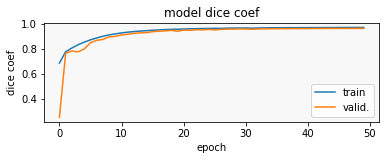

In [24]:
display_training_curves(
    history.history[ 'dice_coef' ], 
    history.history[ 'val_dice_coef' ], 
    'dice coef', 
    212
)

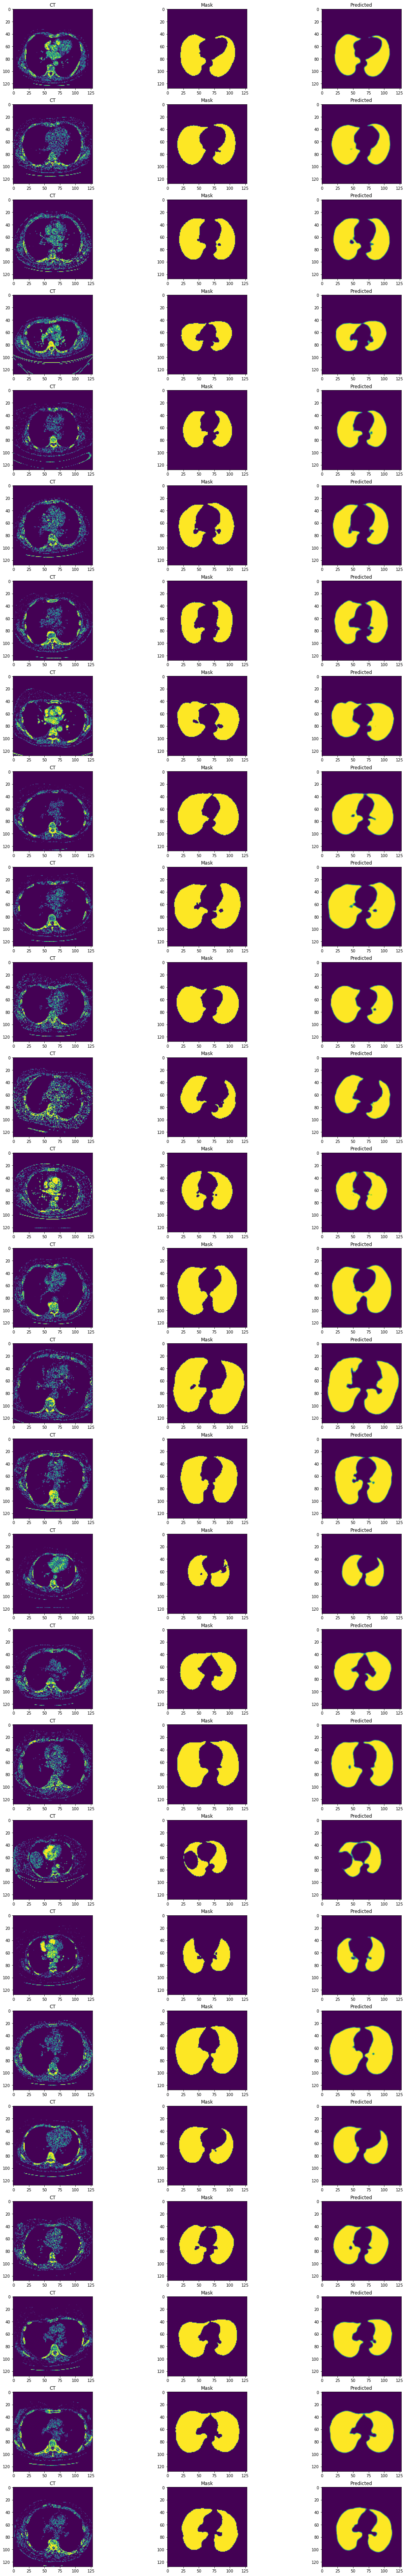

In [25]:
y_hat = model.predict( x_val )

fig, ax = plt.subplots( len( y_hat ), 3, figsize = ( 20, 120 ) )
for i in range( len( y_hat ) ):
    ax[i, 0].imshow( x_val[ i, :, :, 0 ] )
    ax[i, 1].imshow( y_val[ i, :, :, 0 ] )
    ax[i, 2].imshow( y_hat[ i, :, :, 0 ] )
    
    # set titles
    ax[i, 0].set_title( 'CT' )
    ax[i, 1].set_title( 'Mask' )
    ax[i, 2].set_title( 'Predicted' )

In [43]:
# Save figure
fig.savefig('result.png')